# `STARSKØPE-2`



**Building a Cyberoptic Neural Network Telescope for Astrophysical Object Classification**

> Flatiron School Capstone Project
* `Ru Keïn`
* `Instructor: James Irving PhD`
* `Data Science Full-Time Program`
* `Blog post URL:`
* `Non-Technical Presentation`:

# Import

Once again let's import the requisite libraries and our dataset.

In [2]:

import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import dataset which has already been split into train and test sets, `exoTrain.csv.zip` and `exoTest.csv.zip` (I compressed them from their original csv format since the training set is > 240 MB so we'll to unzip them).

In [3]:
# Use this instead if using Jupyter notebook/local
# import os, glob, sys
# home = os.path.abspath(os.curdir)
# os.listdir(home)
# %cd ../
# %cd data
# %ls


# navigating to dataset on google colabs - step 1 mount drive
from google.colab import drive
drive.mount('/gdrive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [14]:
%cd /gdrive

/gdrive


In [16]:
# google colabs step 2 - change directory to `data`
%cd 'My Drive/Colab Notebooks/starskope/data'/
%ls

/gdrive/My Drive/Colab Notebooks/starskope/data
 cumulative.csv                         exoTrain.csv.zip
 emissionspec_2020.01.30_19.43.11.csv  'Icon'$'\r'
 exoTableDraw.R                         __MACOSX/
 exoTest.csv                            oec.csv
 exoTest.csv.zip                        transitspec_2020.01.30_19.38.06.csv
 exoTrain.csv


In [0]:
# uncomment below if you need to unzip the data files
# !unzip -q 'exoTrain.csv.zip'
# !unzip -q 'exoTest.csv.zip'
# %ls

In [0]:
# read in train and test files
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [18]:
# cd backto home / root directory
%cd ../

/gdrive/My Drive/Colab Notebooks/starskope


In [19]:
# We will want to do our own train-test split rather than use the default splitting
# So let's combine the train and test datasets into one
# Both indexes begin with 0 so we need to adjust the index to avoid duplicates/overlap

idx2 = list(range(5088,5658)) # the train dataset index ends with 5087
idx2 = pd.Series(idx2)
idx2

0      5088
1      5089
2      5090
3      5091
4      5092
       ... 
565    5653
566    5654
567    5655
568    5656
569    5657
Length: 570, dtype: int64

In [20]:
test = test.rename(index=idx2)
test.tail()

LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
5653      1   374.46   326.06  ...    -213.63    -205.99    -194.07
5654      1    -0.36     4.96  ...      -5.32     -10.98     -11.24
5655      1   -54.01   -44.13  ...       5.47      14.46      18.70
5656      1    91.36    85.60  ...      -8.43      -6.48      17.60
5657      1  3071.19  2782.53  ...    -277.22     -69.63     121.56

[5 rows x 3198 columns]

In [21]:
# Now we can combine training and test datasets 

exodata = train.append(test)
exodata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5657 entries, 0 to 5657
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 138.1 MB


In [0]:
# create datasets for spectographs
planets = exodata.loc[exodata['LABEL'] == 2]
negatives = exodata.loc[exodata['LABEL'] == 1]

In [0]:
# Prep data for ML : Separate target and feature datasets
# TARGETS
y_train = train['LABEL']
y_test = test['LABEL']

# FEATURES
x_train = train.copy().drop(columns=['LABEL'], axis=1)
x_test = test.copy().drop(columns=['LABEL'], axis=1)


In [0]:
# create datasets for spectographs
train_planets = train.loc[train['LABEL'] == 2]
train_negatives = train.loc[train['LABEL'] == 1]
test_planets = test.loc[test['LABEL'] == 2]
test_negatives = test.loc[test['LABEL'] == 1]

In [0]:
# create folders for storing training spectographs
# %mkdir train_planets
# %mkdir train_negatives

# # create folders for storing test spectographs
# %mkdir test_planets
# %mkdir test_negatives

# setup paths for storing images in folders created above 
from os import path

train_planets_outpath = "./train_planets"
test_planets_outpath = "./test_planets"

train_negatives_outpath = "./train_negatives"
test_negatives_outpath = "./test_negatives"

## Spectographs

In [0]:
    # create function for generating and saving spectograph figs
def make_specgram(signal, Fs=None, NFFT=None, noverlap=None, mode=None,
                  cmap=None, units=None, colorbar=False, 
                  save_for_ML=False, fname=None,num=None,**kwargs):
    import matplotlib
    import matplotlib.pyplot as plt
    if mode:
        mode=mode
    if cmap is None:
      cmap='binary'

    #PIX: plots only the pixelgrids -ideal for image classification
    if save_for_ML == True:
        # turn off everything except pixel grid
        colorbar==False
        units==False
        frameon=False
        facecolor=False
        figsize=(10,10)
        fig, ax = plt.subplots(figsize=figsize,frameon=False)
        fig, freqs, t, m = plt.specgram(signal, Fs=2, NFFT=256, mode=mode,cmap=cmap);
        plt.axis(False)
        
        plt.show();
        if fname is not None:
            try:
                if num:
                    path=fname+num
                else:
                    path=fname
                plt.savefig(fname+num,**pil_kwargs)
            except:
                Error('Something went wrong while saving the img file')

    else:
        fig, ax = plt.subplots(figsize=(13,11))
        fig, freqs, t, m = plt.specgram(signal, Fs=2, NFFT=256, mode=mode,cmap=cmap);
        plt.colorbar();
        if units is None:
            units=['Wavelength (λ)','Frequency (ν)']
        plt.xlabel(units[0]);
        plt.ylabel(units[1]);
        if num:
            title=f'Spectogram_{num}'
        else:
            title='Spectogram'
        plt.title(title)
        plt.show();

    return fig, freqs, t, m

[24, 12, 6, 3]


213.36

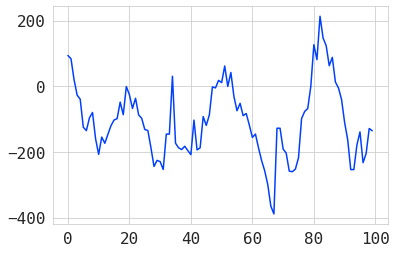

In [422]:
hz128 = signal.size//128 # 128*8 = 1024
hz256 = signal.size//256 # 256*4 =1024
hz512 = signal.size//512 # 512*2 = 1024
hz1024 = signal.size//1024 # 1024*1 = 1024

harmonics = [hz128,hz256,hz512,hz1024]
print(harmonics)
#hz528 = signal.size/528 # 512*2 = 1024
# a1 = np.fft.fft(signal, axis=signal[24])
# a2 = np.fft.fft(signal, axis=len(signal)//2)
#1 = signal.reshape()
splits = np.split(signal, 23)
s0 = splits[0]
s1 = splits[1]
s2 = splits[2]
s3=splits[3]

#8*8*8 = 512
#3197/32 =100
S = np.array([s0,s1,s2,s3])
S.shape
s100 = signal[0:100]
s200 = signal[50:150]
s300 = signal[100:200]
s400 = signal[150:250]


plt.plot(s100)
# plt.plot(s200)
# plt.plot(s300)
# plt.plot(s400)
# np.argmin(s100) #67 
# np.argmax(s100) #82
# s100[67] -388
# s100[82] 213



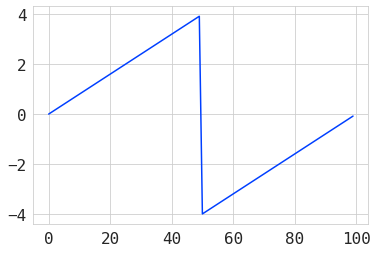

In [445]:
fft_s0 = np.fft.fft(s100)
shift_s0 = np.fft.fftshift(fft_s0)
freq_s0 = np.fft.fftfreq(fft_s0.size,d=1/8)
plt.plot(freq_s0)

931 2839


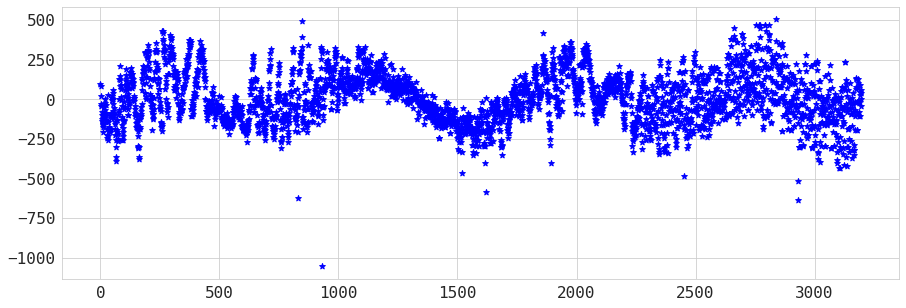

In [318]:

scaled = signal/528
ymin = np.argmin(signal)
ymax = np.argmax(signal)

print(ymin,ymax)

y = train.iloc[0,1:]
x = np.arange(x.size)

plt.figure(figsize=(15,5))
plt.scatter(x,y,marker='*', color='b')

plt.show();

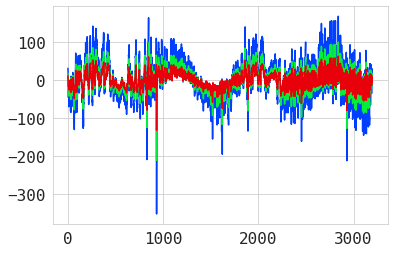

In [297]:
#plt.plot(signal*8)
plt.plot(signal//3)
plt.plot(signal//5)
plt.plot(signal//8)


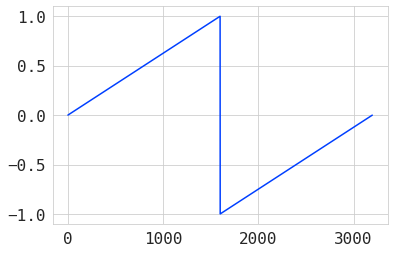

In [140]:
raw
raw = np.array(x_train.iloc[0])
print(raw)
plt.plot(raw)

#signal_plots(raw)


#fast fourier (fft)
fft = np.fft.fft(raw))
fft_shift = np.fft.fftshift(fft)
fft_freq = np.fft.fftfreq(n=fft.size,d=.5)
fft_freq_shift = np.fft.fftshift(fft_freq)

#inverse fft
ifft = np.fft.ifft()

#hfft
hf = np.fft.hfft(signal)#,norm='ortho')
print(hf)

#rfft
rf = np.fft.rfft(signal)

#fft
f = np.fft.fft(signal)#,norm='ortho')
print(f)



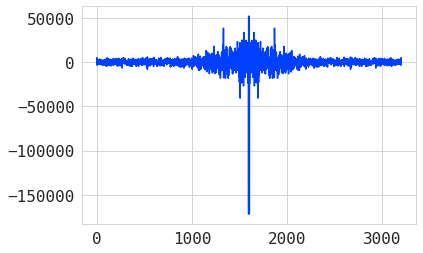

In [141]:
plt.plot(np.fft.fftshift(fn))

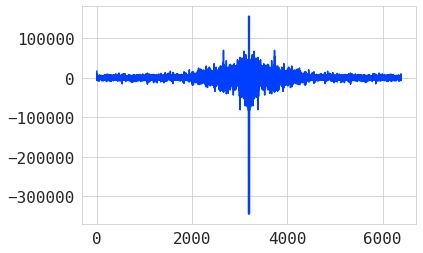

In [133]:
plt.plot(np.fft.fftshift(f))

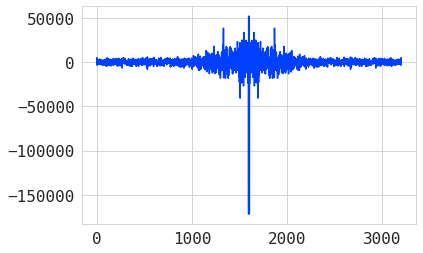

In [134]:
plt.plot(np.fft.fftshift(f2))
plt.plot(np.fft.fftshift(rf))
make_specgram(rf,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='psd')
make_specgram(rf,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='phase')
make_specgram(rfs,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='psd')
make_specgram(rfs,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='phase')
make_specgram(rfs,Fs=2,cmap='magma_r',save_for_ML=True,mode='phase')

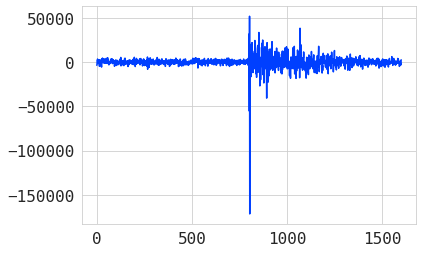

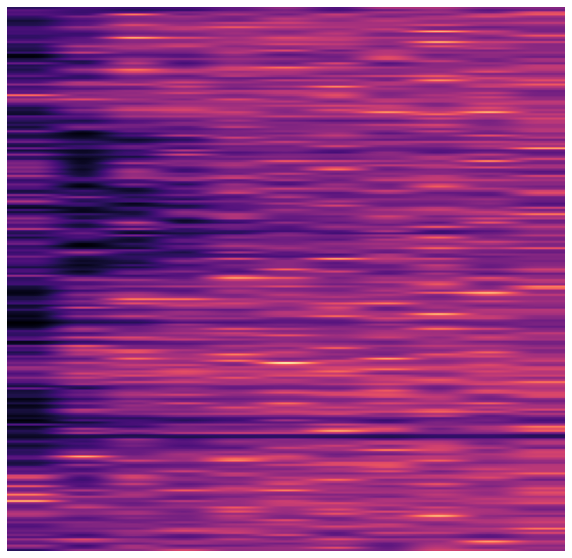

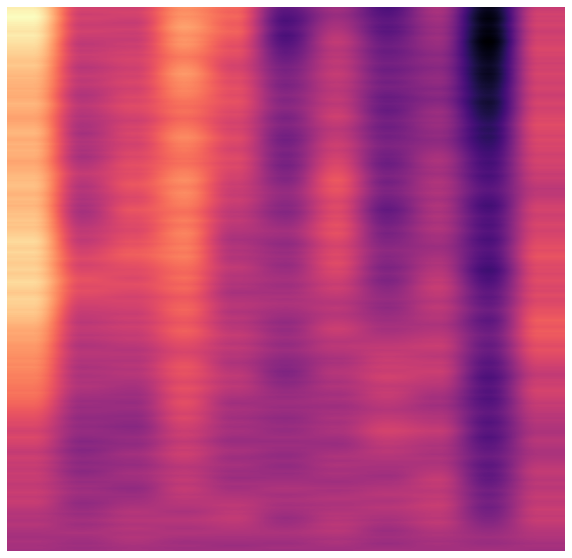

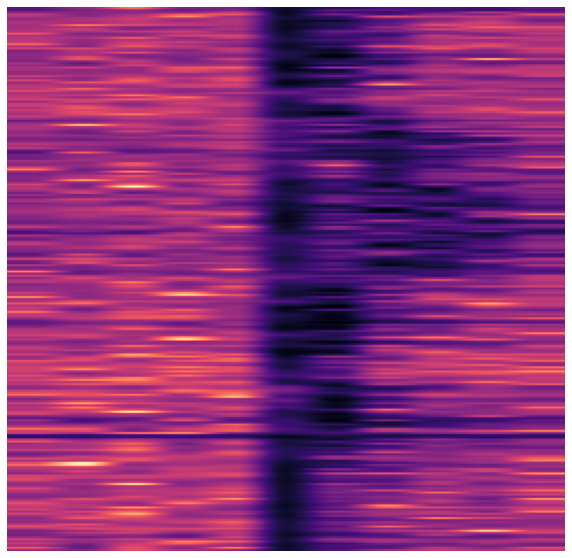

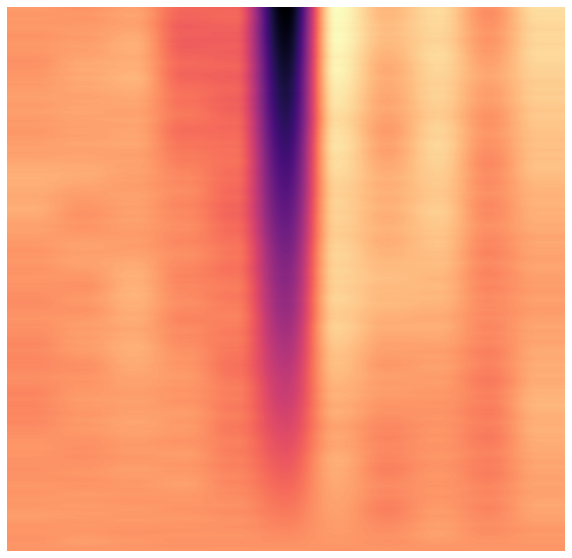

(array([[-4.02193666e-02, -4.61409805e-01, -2.61428137e+00, ...,
          6.74583421e-01, -9.70350206e-01, -1.81190262e+00],
        [ 1.55118386e+00, -3.57796570e+00, -1.07905758e+00, ...,
         -1.30196026e+00, -2.51032157e+00, -2.01301365e+00],
        [-1.38219179e+00, -6.59443692e+00,  2.91393343e-01, ...,
         -2.92634335e+00,  3.98918212e-01,  7.88382433e-01],
        ...,
        [-3.84330180e+00, -2.17951769e+00, -1.97859885e+01, ...,
         -1.05984007e+02,  1.22600754e+01, -1.06202933e+02],
        [-6.49886015e+00,  7.27903741e-01, -1.74140971e+01, ...,
         -1.03747298e+02,  1.01523833e+01, -1.08617417e+02],
        [-9.45177864e+00,  3.53372579e+00, -1.55484255e+01, ...,
         -1.00956005e+02,  7.26085533e+00, -1.11335323e+02]]),
 array([-1.       , -0.9921875, -0.984375 , -0.9765625, -0.96875  ,
        -0.9609375, -0.953125 , -0.9453125, -0.9375   , -0.9296875,
        -0.921875 , -0.9140625, -0.90625  , -0.8984375, -0.890625 ,
        -0.8828125, -0.87

In [451]:
plt.plot(np.fft.fftshift(rf))
make_specgram(rf,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='psd')
make_specgram(rf,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='phase')
make_specgram(rfs,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='psd')
make_specgram(rfs,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,mode='phase')
#make_specgram(rfs,Fs=2,cmap='magma_r',save_for_ML=True,mode='phase')

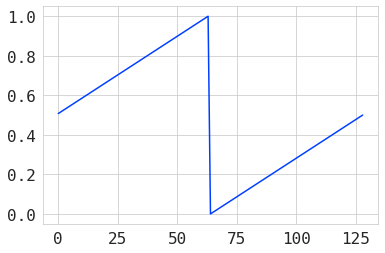

In [164]:
shifted_freqs= np.fft.fftshift(freqs)
plt.plot(shifted_freqs)

#plt.plot(np.fft.fftshift(freqs))

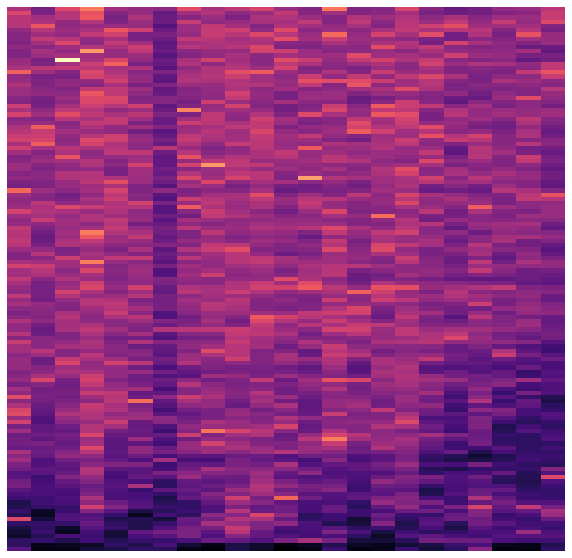

In [64]:
# generating specs for image classification 
sig=np.array(train_planets.iloc[0, 1:])
fig, freqs, t, m  = make_specgram(sig,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,)

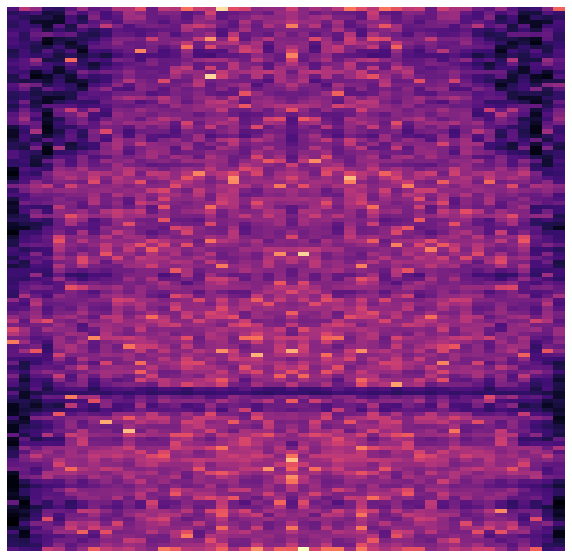

In [162]:
# fourier transformed signal frequency specgram
ffspec, ffqs, ft, fm  = make_specgram(f,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,)

In [0]:
rfs = np.fft.fftshift(rf)
fns = np.fft.fftshift(fn)
fs = np.fft.fftshift(f)
f2s =np.fft.fftshift(f2)




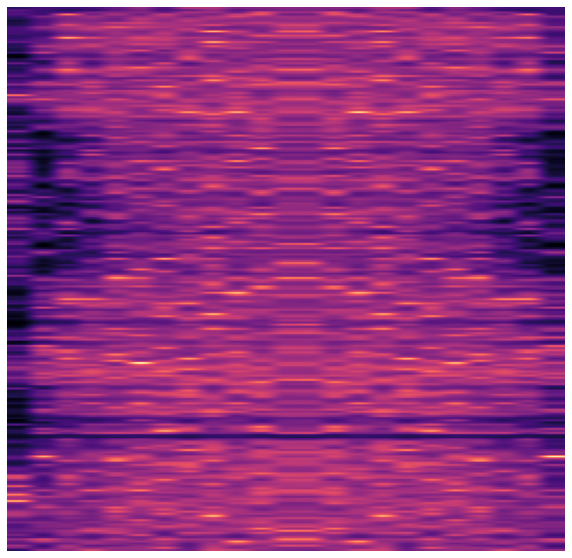

In [75]:
ff2spec, ff2qs, f2t, f2m  = make_specgram(f2,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,)

In [0]:
# ~3200 signals
# 3200 / 512 =  
# 3200 / 128 = 25 (64*2)
# 3200 / 64 = 50  (8*8)

    #make_specgram(s100,Fs=2,pad_to=528,cmap='magma_r',save_for_ML=True,)
3200/4 # 800
800/4# 200
200 / 4 # 50
#16*4 = 64 
3200/25

sigplus = np.zeros(3)
for i in range(3):
    sigplus += np.random.choice(signal)





In [519]:
signal.append(sigplus).reshape(3197)

AttributeError: ignored

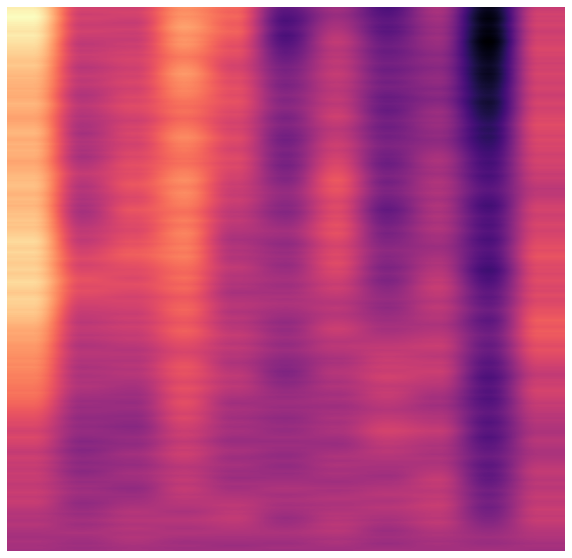

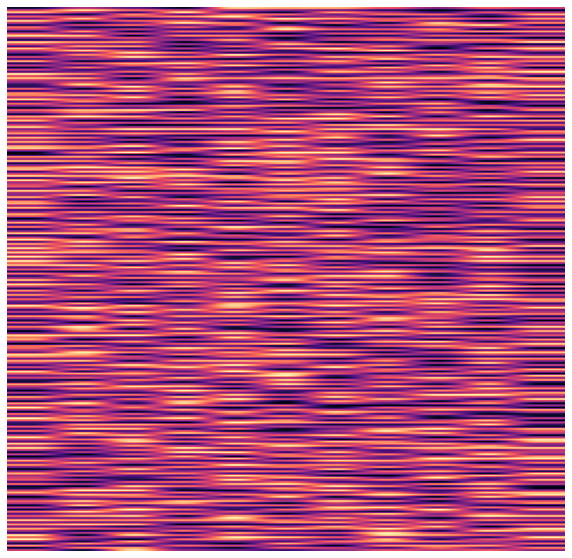

In [79]:
afp, fpq, fpt, fpm  = make_specgram(f,Fs=2,pad_to=528,cmap='magma_r',mode='phase',save_for_ML=True,)
fa, faq, fat, fam  = make_specgram(f,Fs=2,pad_to=528,cmap='magma_r',mode='angle',save_for_ML=True,)

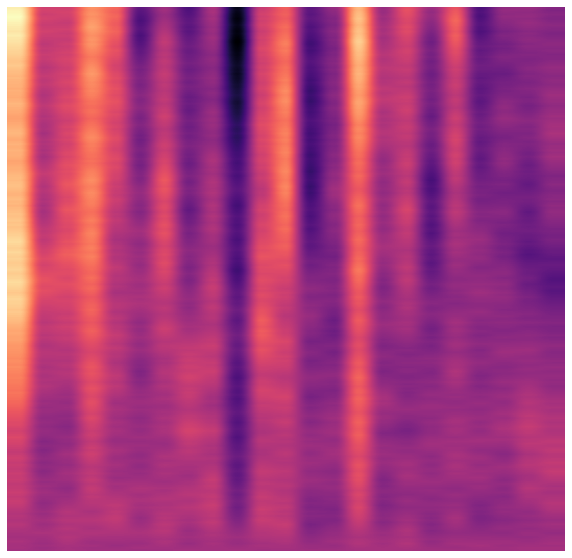

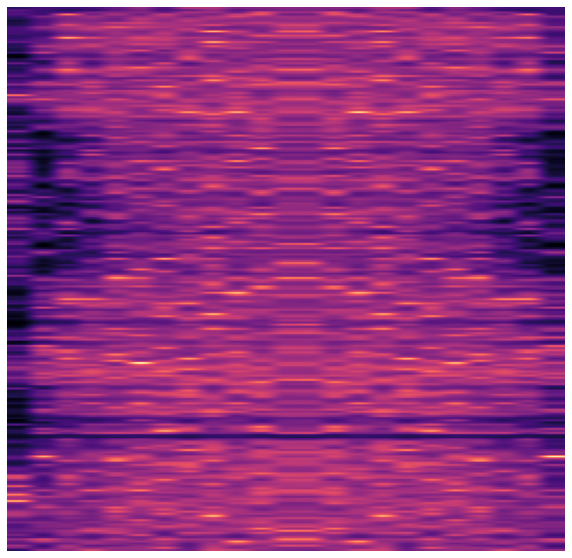

In [151]:
f2p, f2pq, f2pt, f2pm  = make_specgram(f2,Fs=2,pad_to=528,cmap='magma_r',mode='phase',save_for_ML=True,)
f2a, f2aq, f2at, f2am  = make_specgram(f2,Fs=2,pad_to=528,cmap='magma_r',mode='magnitude',save_for_ML=True,)

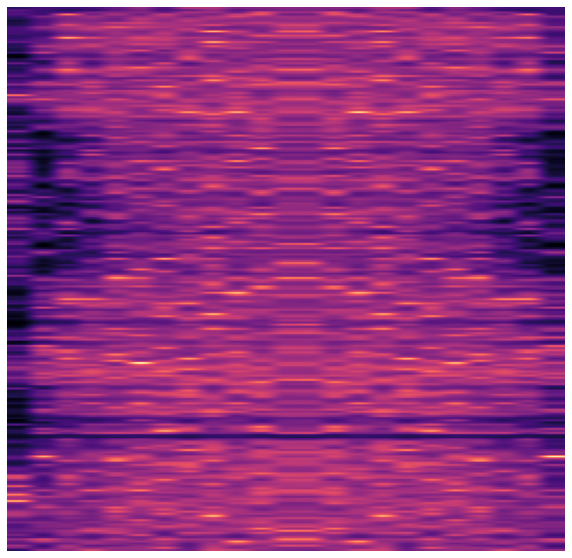

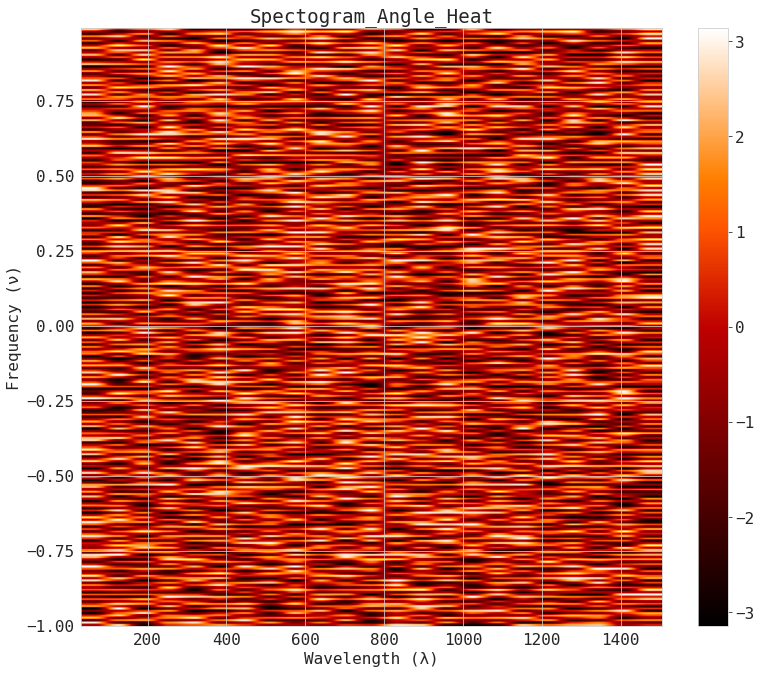

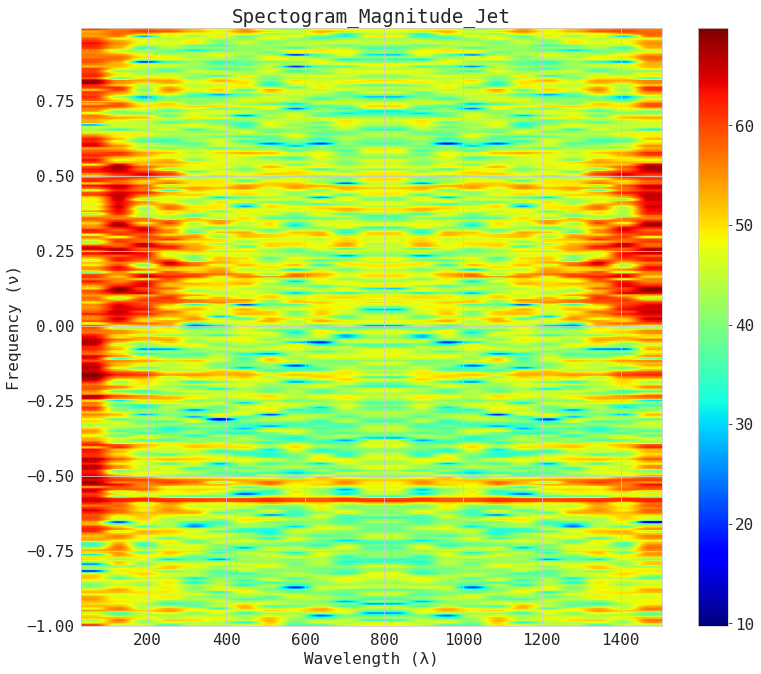

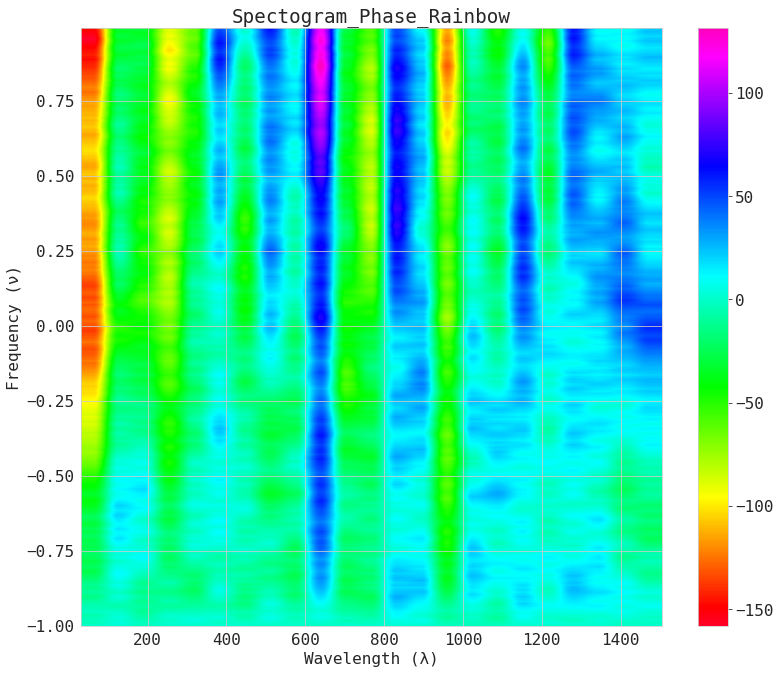

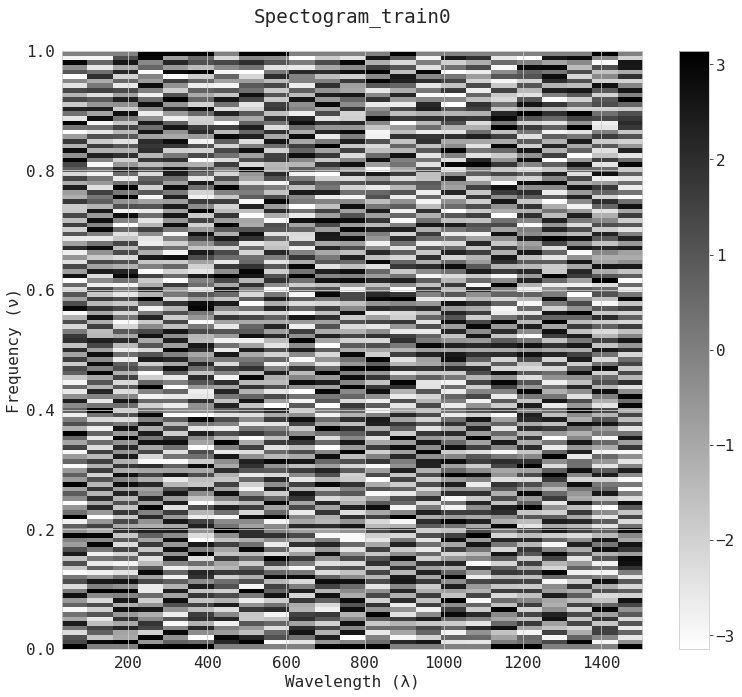

In [94]:
#gist_heat
angle_spec, freqs, t, m = make_specgram(f2, NFFT=256,Fs=2, cmap='gist_heat',mode='angle',num='Angle_Heat')
#jet
mag_spec, freqs, t, m = make_specgram(f2, NFFT=256,Fs=2, cmap='jet',mode='magnitude',num='Magnitude_Jet')
# gist_rainbow
phase_spec, freqs, t, m = make_specgram(f2, NFFT=256,Fs=2, cmap='gist_rainbow',mode='phase',num="Phase_Rainbow")


fig, freqs, t, m  = make_specgram(sig,Fs=2,mode='angle',cmap='binary',num='train0\n')
# plt.colorbar()
# plt.xlabel('Time')
# plt.ylabel('Freq')

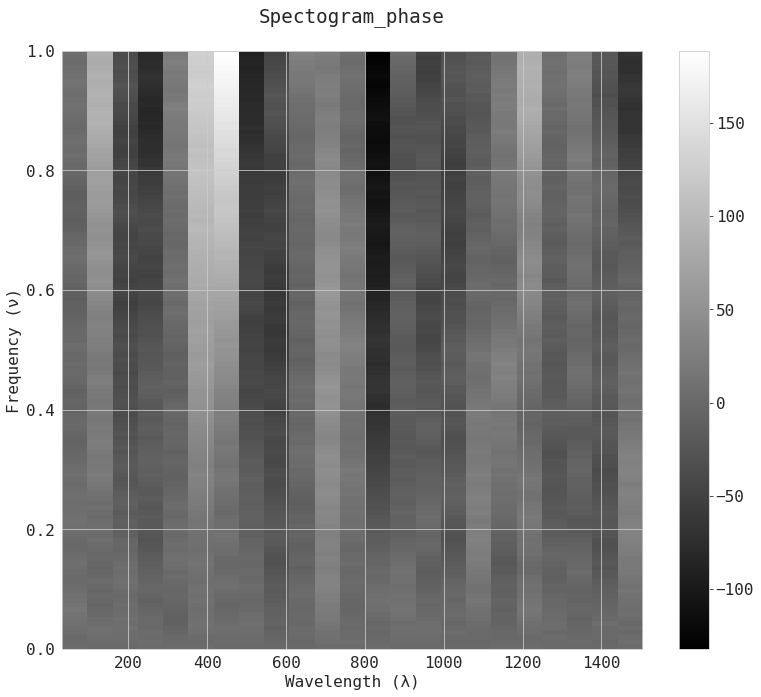

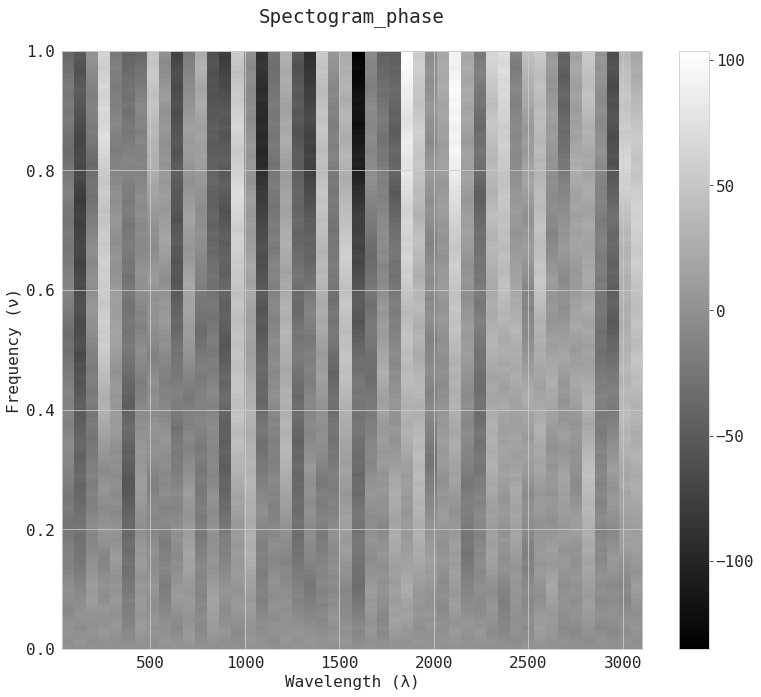

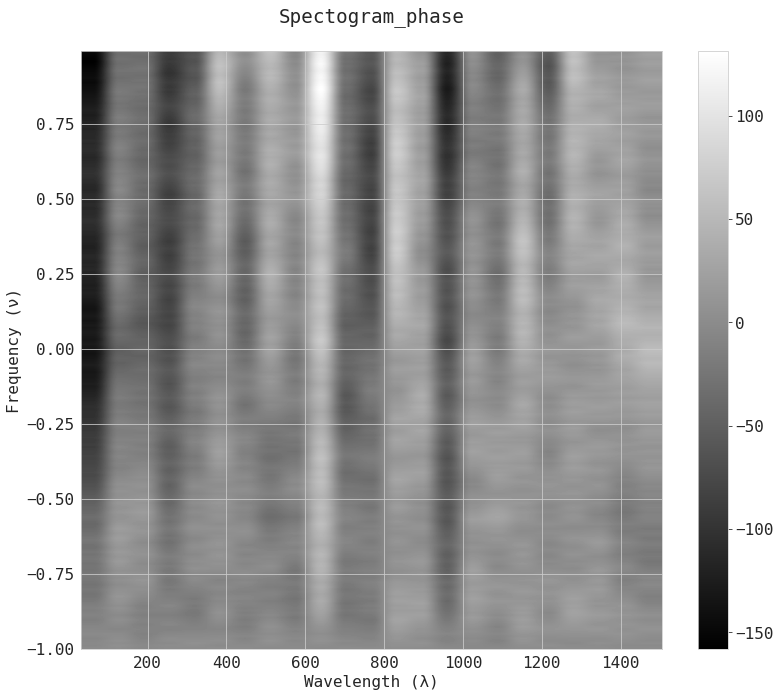

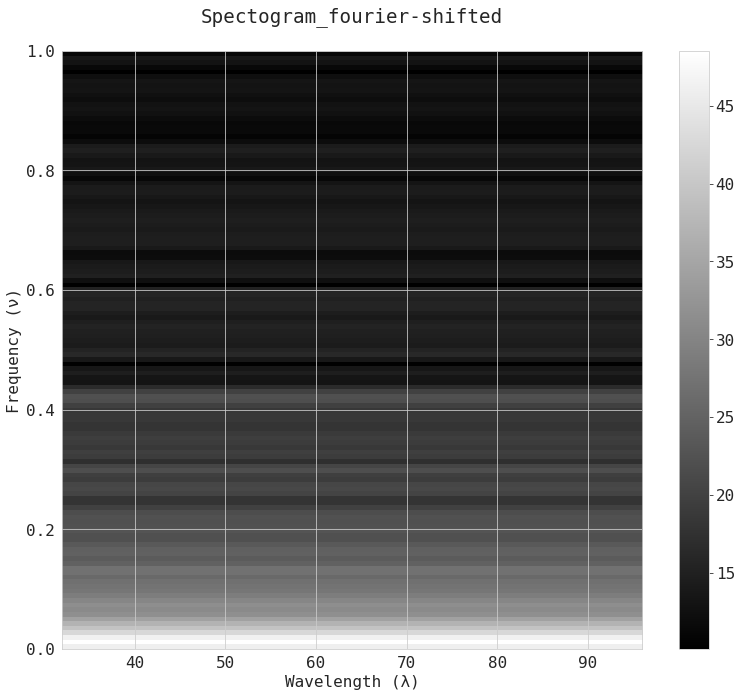

In [149]:
fig, freqs, t, m  = make_specgram(sig,Fs=2,noverlap=.5,cmap='binary_r',mode='phase',num='phase\n')
ffig, ffreqs, t, m  = make_specgram(f,Fs=2,noverlap=.5,cmap='binary_r',mode='phase',num='phase\n')
f2ig, f2freqs, t, m  = make_specgram(f2,Fs=2,noverlap=.5,cmap='binary_r',mode='phase',num='phase\n')
fshifted, fqshift, fqt, fqm  = make_specgram(fshift,Fs=2,noverlap=.5,cmap='binary_r',num='fourier-shifted\n')
# 23*6
# 3197/139/23
# t

In [85]:
print('mean:',freqs.mean())
print('std:',freqs.std())
print('len:',len(freqs))
print('sum:',sum(freqs))

print(freqs.shape)


mean: 0.5
std: 0.2909216675785196
len: 129
sum: 64.5
(129,)


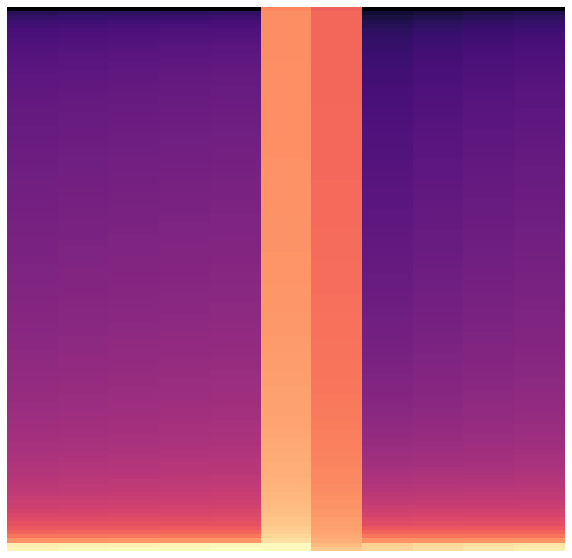

In [93]:
fsig= np.fft.rfft(sig)
rf = np.fft.rfftfreq(n=sig.size,d=1/9)
rfshift=np.fft.fftshift(rf)
rfspec, rfqs, t, m = make_specgram(rfshift,Fs=2,cmap='magma',mode='psd',save_for_ML=True)
#spec, freqs, t, m = make_specgram(sig,Fs=2,cmap='magma',mode='phase',save_for_ML=True)

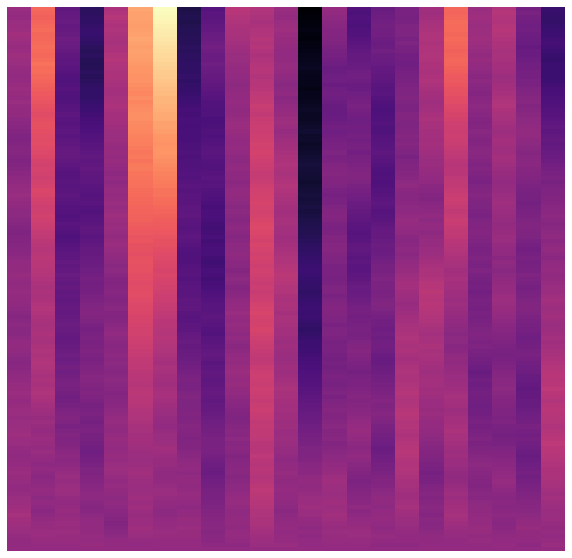

In [726]:
phase_spec, phase_fqs, t, m = make_specgram(sig,Fs=2,cmap='magma',mode='phase',save_for_ML=True)



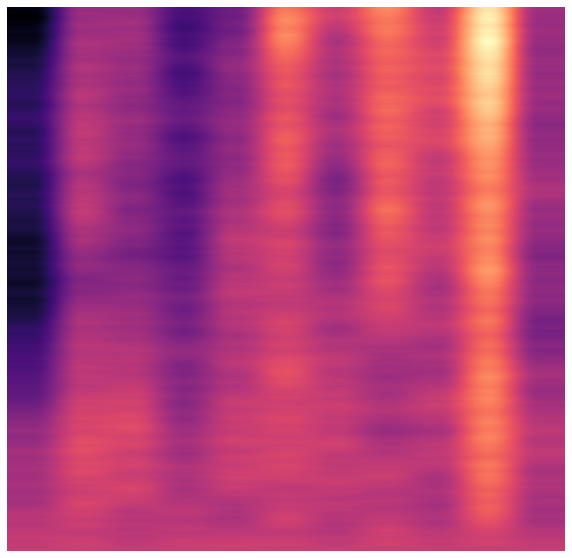

In [598]:
fphase, pfq, t, m = make_specgram(fsig,Fs=2,cmap='magma',mode='phase',save_for_ML=True)

In [599]:
display(phase_spec.shape,fphase.shape)

(129, 23)

(256, 11)

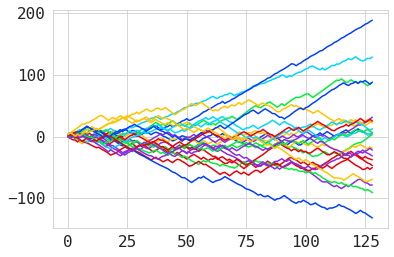

In [630]:
plt.plot(phase_spec);

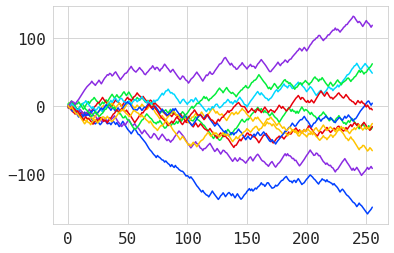

In [628]:
plt.plot(fphase);

In [0]:
# !pip install astropy
# !pip install specutils

import astropy.units as u

In [637]:
from specutils import Spectrum1D
import astropy.units as u
import numpy as np

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm, flux=np.random.sample(49)*u.Jy)
spec2 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm, flux=np.random.sample(49)*u.Jy)
spec3 = spec1 + spec2
spec3 

<Spectrum1D(flux=<Quantity [1.42177604, 1.5298894 , 1.0607101 , 1.76343527, 1.81561639,
           1.93204587, 0.67444392, 0.43714108, 0.69284708, 0.23156041,
           0.65490624, 1.05083211, 1.59079083, 1.37772534, 0.84663496,
           1.25400602, 1.19308975, 0.73715283, 0.68697398, 0.24250885,
           0.48239196, 0.29856181, 0.93343179, 1.36667996, 0.61628621,
           0.97470572, 0.9475632 , 0.32377013, 1.08254946, 1.14682727,
           1.34467584, 0.69691523, 1.14249688, 1.19885566, 1.33475671,
           0.80970613, 1.2312674 , 1.06139857, 0.88984631, 0.75855322,
           0.89636418, 0.42183126, 0.3978719 , 0.44818341, 0.43784785,
           1.21718613, 1.5924773 , 0.82152563, 0.94262691] Jy>, spectral_axis=<SpectralCoord [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
                13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
                25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.,
                37., 38., 39., 40., 41

In [696]:
flux1 = np.asarray(spec1.flux)
flux2 = np.asarray(spec2.flux)



24.738647539416434

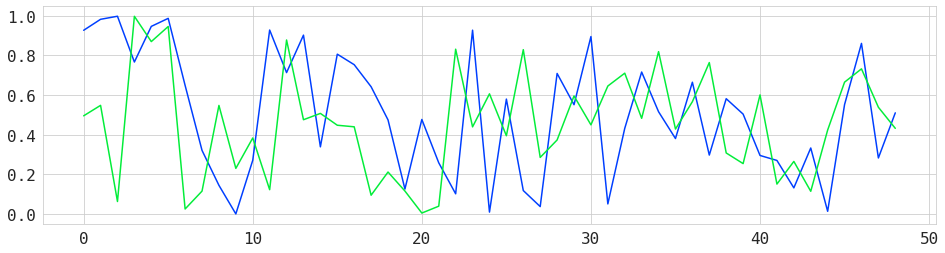

<Figure size 1152x288 with 0 Axes>

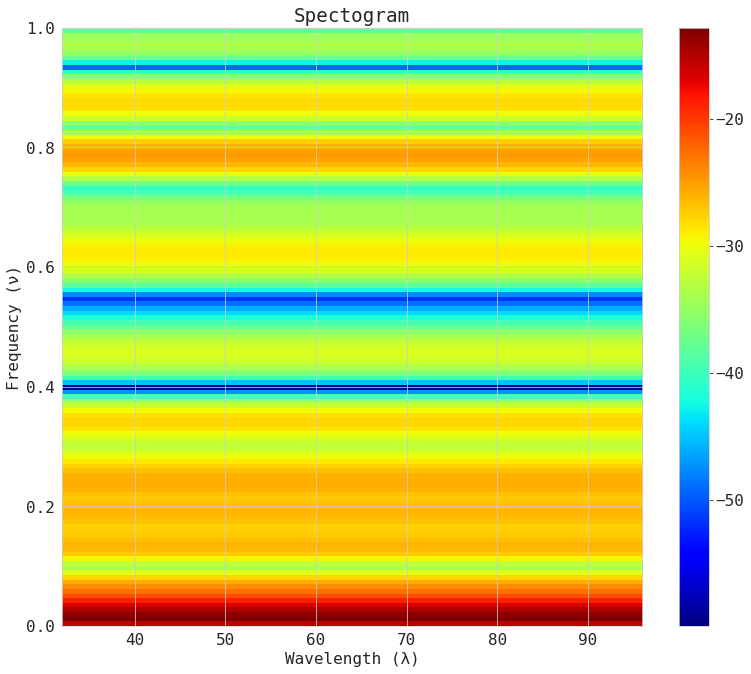

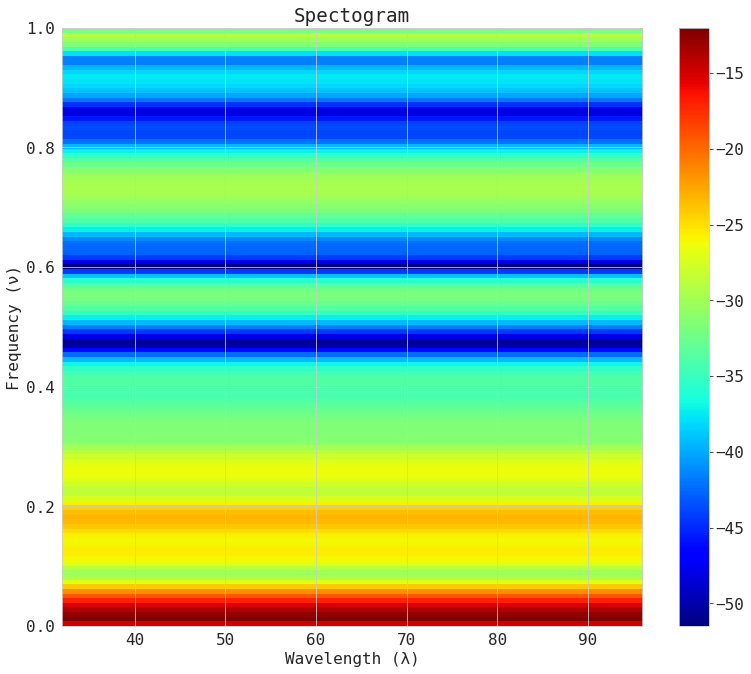

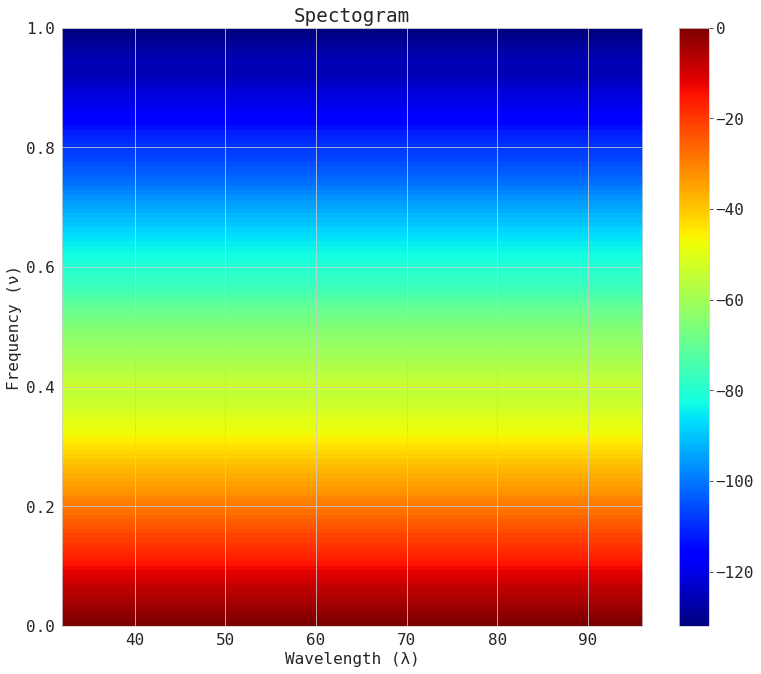

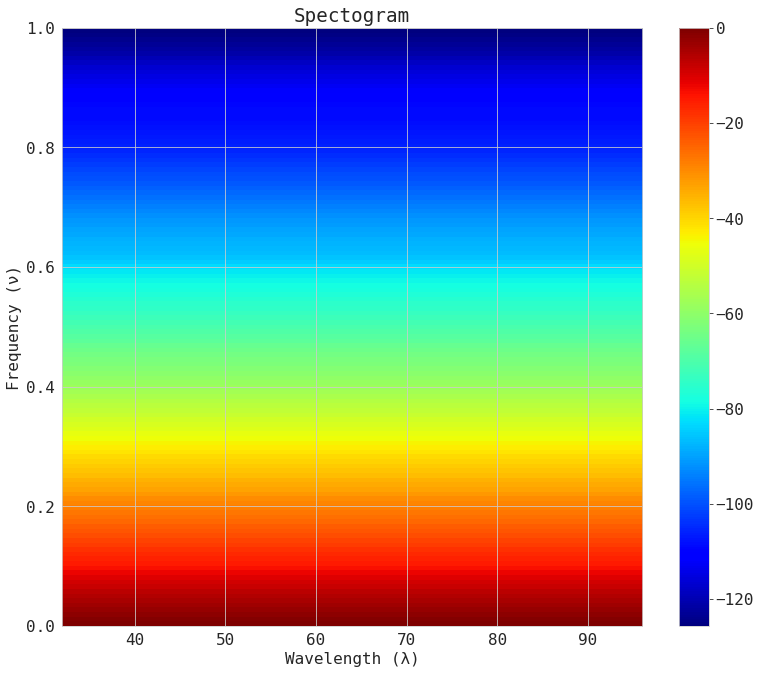

In [713]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(16,4),sharey=True)

ax=plt.plot(flux1)
ax=plt.plot(flux2)

fig = plt.figure(figsize=(16,4))

fig, Fq, t, m = make_specgram(flux1, mode='psd', cmap='jet')
fig, Fq, t, m = make_specgram(flux2, mode='psd', cmap='jet')

fig, Fq, t, m = make_specgram(flux1, mode='phase', cmap='jet')
fig, Fq, t, m = make_specgram(flux2, mode='phase', cmap='jet')

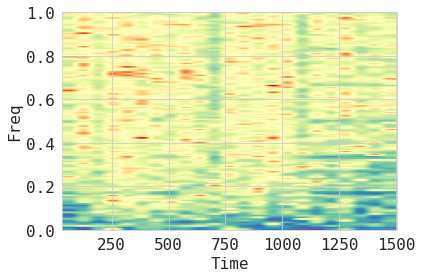

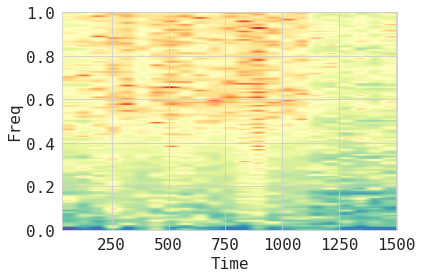

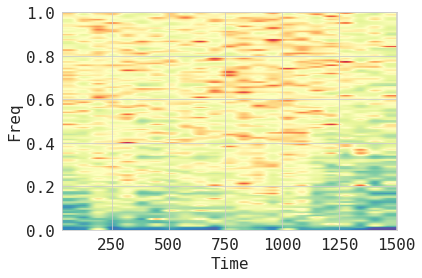

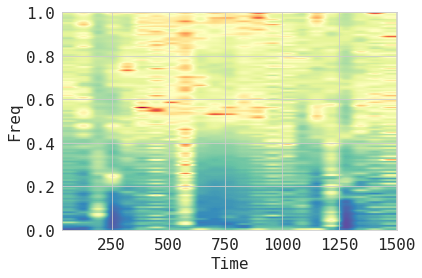

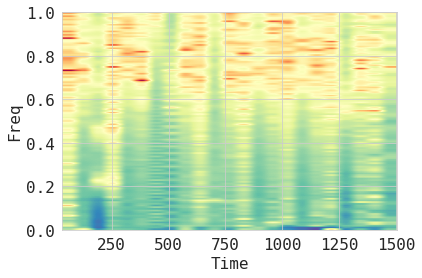

In [333]:
# create spectographs for test set - planets
for i in test_planets.index:
    signal = np.array(test_planets.iloc[i])
    make_specgram(signal,cmap='Spectral')
    #plt.savefig(path.join(test_planets_outpath,'spec_{0}.png'.format(i)))
    # make_specgram(f_sig, cmap='binary')

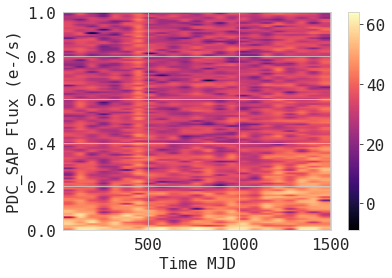

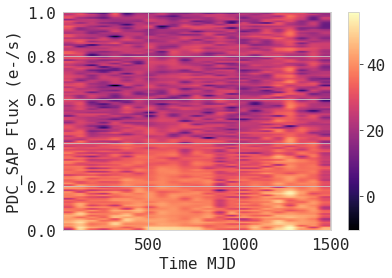

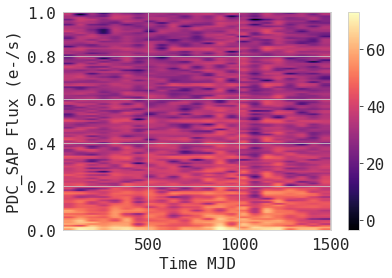

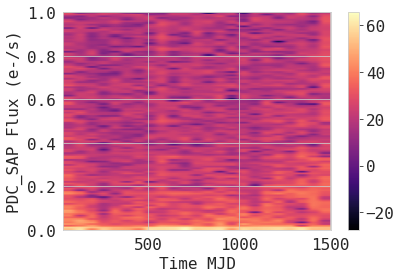

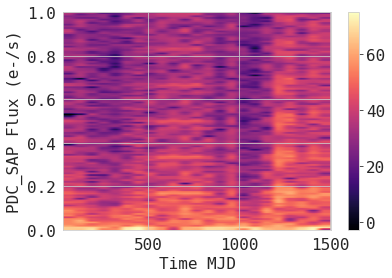

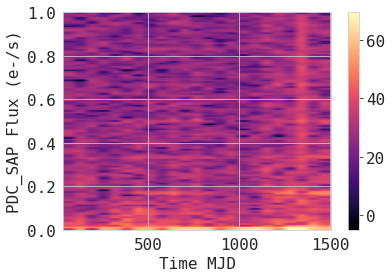

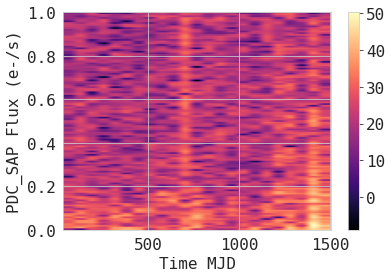

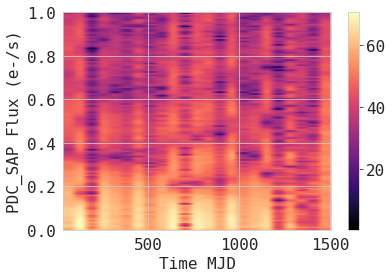

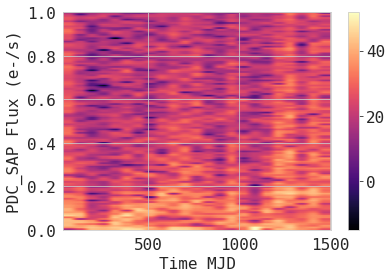

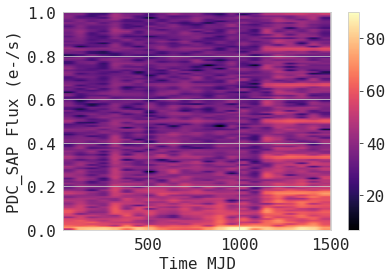

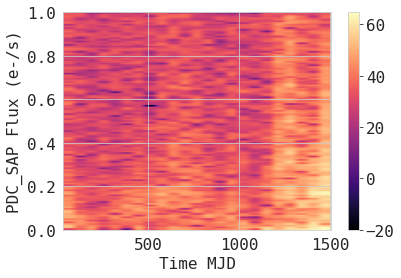

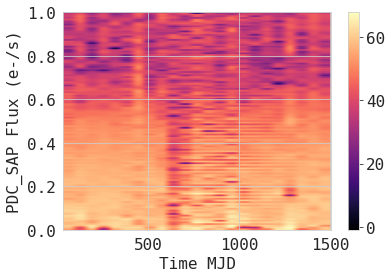

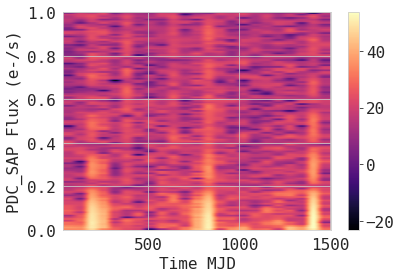

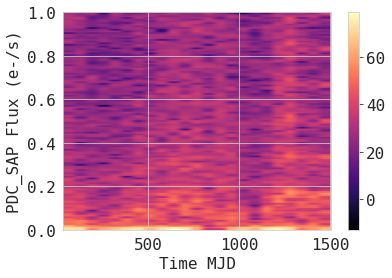

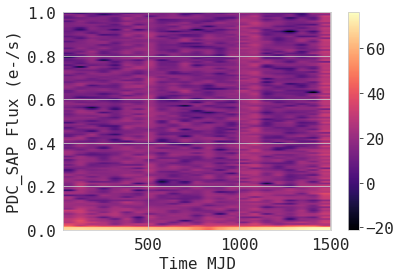

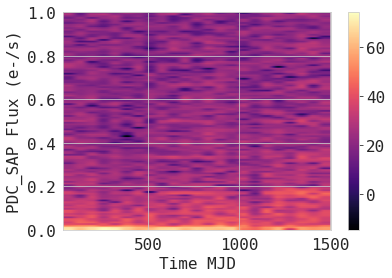

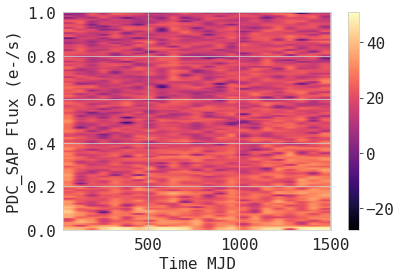

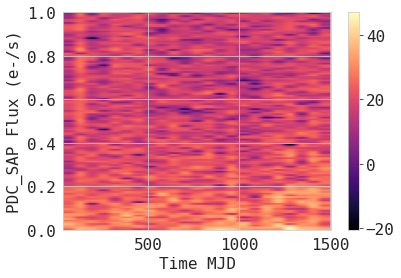

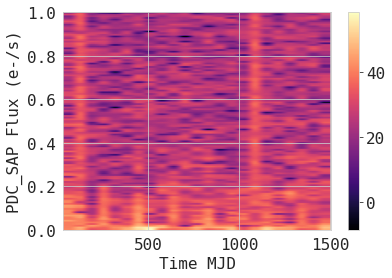

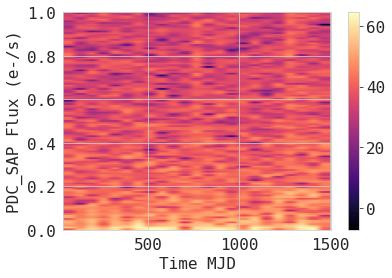

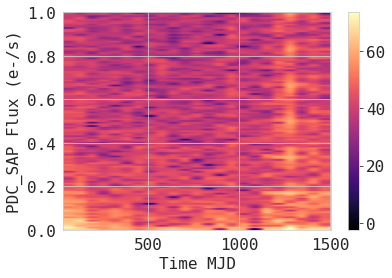

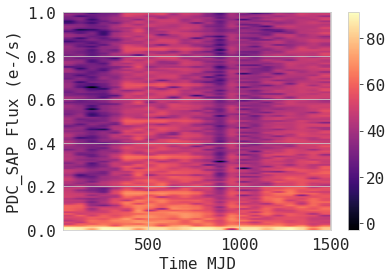

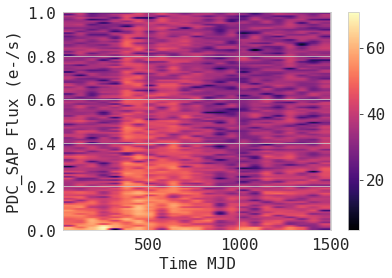

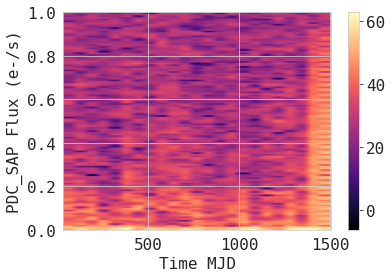

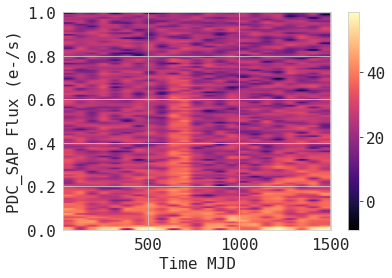

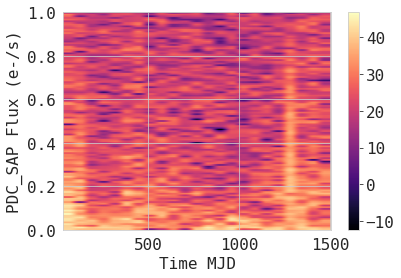

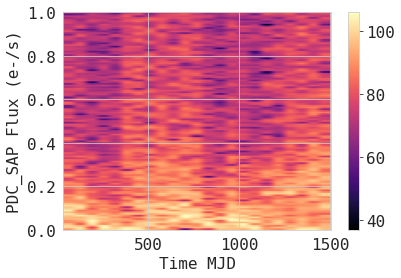

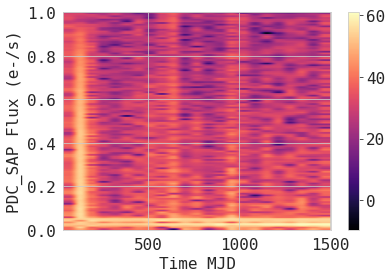

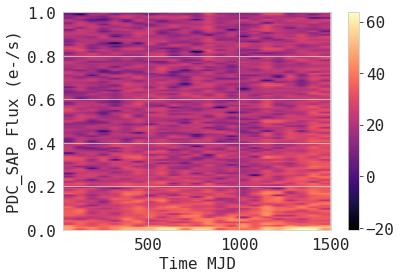

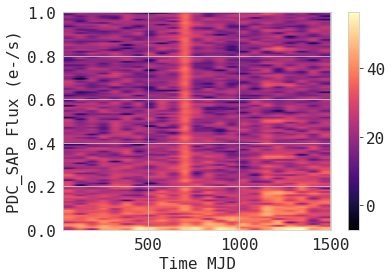

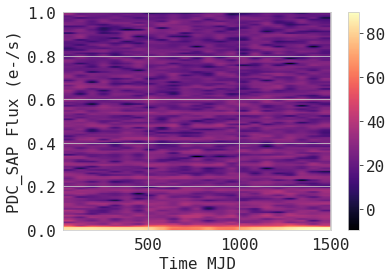

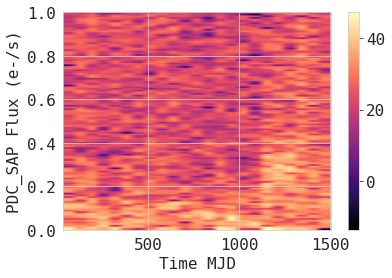

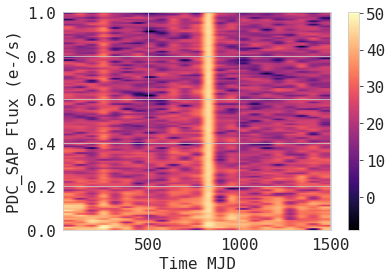

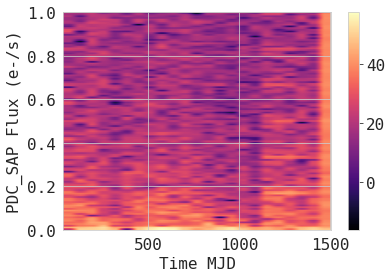

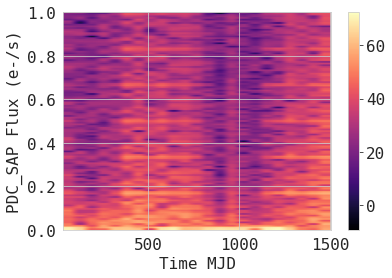

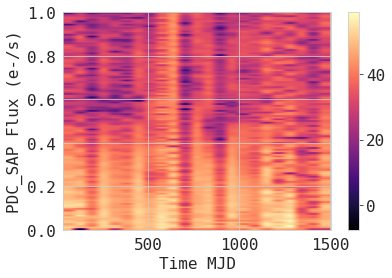

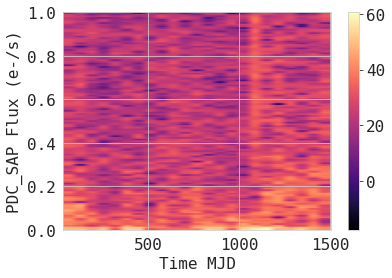

In [20]:
# create spectographs for training set - planets
for i in train_planets.index:
    signal = np.array(train_planets.iloc[i])
    make_specgram(train_planets)
    plt.savefig(path.join(train_planets_outpath,'train_planets_{0}.png'.format(i)))

In [0]:
# create spectographs for training set - NO planets
for i in train_negatives.index:
    signal = np.array(train_negatives.iloc[i])
    make_specgram(train_negatives)
    plt.savefig(path.join(train_negatives_outpath,'train_negatives_{0}.png'.format(i)))

In [0]:
# create spectographs for test set - NO planets
for i in test_negatives.index:
    signal = np.array(test_negatives.iloc[i])
    make_specgram(test_negatives)
    plt.savefig(path.join(test_negatives_outpath,'test_negatives_{0}.png'.format(i)))

In [0]:
from scipy import fftpack 

d_step = 0.250

#Sampling para 3 THz
sample_freq_3T = fftpack.fftfreq(prosolar3.temp.size, d=d_step)
sig_fft_3T     = fftpack.fft(prosolar3.temp)

#Sampling para 7 THz
sample_freq_7T = fftpack.fftfreq(prosolar7.temp.size, d=d_step)
sig_fft_7T     = fftpack.fft(prosolar7.temp)

pidxs_3T = np.where(sample_freq_3T > 0)
freqs_3T = sample_freq_3T[pidxs_3T]
power_3T = np.abs(sig_fft_3T)[pidxs_3T]

pidxs_7T = np.where(sample_freq_7T > 0)
freqs_7T = sample_freq_7T[pidxs_7T]
power_7T = np.abs(sig_fft_7T)[pidxs_7T]

## Train-Test Split

## Preparing Images using Flow

In [0]:
# !pip install pillow
# !pip install opencv-contrib-python

## Prep images using .flow

In [0]:
import cv2,glob,os
import pandas as pd

In [100]:
train_planets['LABEL']

0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
33    2
34    2
35    2
36    2
Name: LABEL, dtype: int64

In [0]:
train_planet_files = glob.glob('train_planets')
train_negative_files = glob.glob('train_negatives')
all_train_files = [*train_planet_files,*train_negative_files]

test_planet_files = glob.glob('test_planets')
test_negative_files = glob.glob('test_negatives')
all_test_files = [*test_planet_files,*test_negative_files]


all_filename_vars = [train_planet_files, train_negative_files,
                        test_planet_files, test_negative_files]

In [35]:
# converting an image with the Keras API

from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
import cv2
from tqdm import tqdm

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

Using TensorFlow backend.


In [0]:
# From James Irving : https://colab.research.google.com/drive/1fwXPY3IDHxNiv7YgOpt3p5BvUaO4VruB#scrollTo=L5CNHxnagDjo

def load_img_cv2(filename, RGB=True):
  import cv2
  IMG = cv2.imread(filename)
  if RGB: cmap = cv2.COLOR_BGR2RGB
  else:
    cmap=cv2.COLOR_BGR2GRAY
  return cv2.cvtColor(IMG, cmap)


# defining a function to read images and convert to array
def read_img(img_path, target_size=(64,64,3)):
  img = image.load_img(img_path, target_size=target_size)
  img = image.img_to_array
  return img

In [109]:
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import save_img
# from keras.preprocessing.image import img_to_array

#img = load_img('train_planets/train_planets_0.png', grayscale=False)

planets_train = []
planets_test = []
neg_train = []
neg_test = []

planets

for img in 'train_planets/':
  img = load_img('train_planets/train_planets_0.png', grayscale=False)
  imga = img_to_array(img)
  planets_train.append(img)

planets_train


[<PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ED484A8>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9518>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9588>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9B70>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9A90>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9AC8>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9CC0>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9A20>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9BE0>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519ECD9C18>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519EC55128>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519EC55198>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519EC55208>,
 <PIL.Image.Image image mode=RGB size=432x288 at 0x7F519EC55278>]

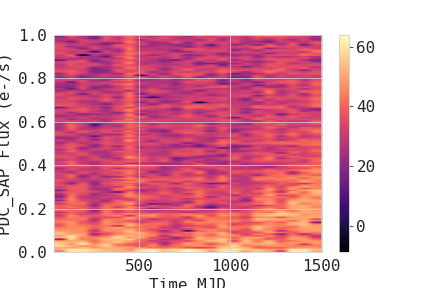

In [110]:
planets_train[0]


In [71]:
#print(img.size) # (432 * 288)
# 432*288 = 124416

# # convert image to a numpy array
img_array = img_to_array(img)
img_array

img.size

(432, 288)

In [74]:
%ls

 assets/       LICENSE      sklearn-sparknotes.ipynb   test_negatives/
 _config.yml   models/      sparknotes.txt             test_planets/
 data/         notebooks/   starskøpe-1.ipynb          todo.md
 DONT_PANIC/   pyFunc/      starskøpe-2.ipynb          train_negatives/
'Icon'$'\r'    README.md    starskøpe.ipynb            train_planets/


In [92]:
type(train_planets)

pandas.core.frame.DataFrame

In [0]:
# Read in training and test filenames to produce X and y data splits.

def load_train_test(train1, train0, test1, test0, 
                    img_size=(64,64,3), val_size=0.1):
  # y labels are encoded as 0=negatives, 1=planets
  # returns X_train, X_test, y_train, y_test, y_val

  display('[i] LOADING IMAGES')

  train_img = []
  train_label = []

  for img in train1:
    train_img.append(read_img(img, target_size=img_size))
    train_label.append(1)

  for img_path in tqdm(train0):
    train_img.append(read_img(img_path, target_size=img_size))
    train_label.append(0)

  test_img = []
  test_label = []

  for img_path in tqdm(test1):
    test_img.append(read_img(img_path, target_size=img_size))
    test_label.append(1)

  for img_path in tqdm(test0):
    test_img.append(read_img(img_path, target_size=img_sie))
    test_label.append(0)

  from sklearn.model_selection import train_test_split
  X = np.array(train_img, np.float32)
  y = np.array(train_label)

  X_test = np.array(test_img, np.float32)
  y_test = np.array(test_label)
  
  X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

  print('\n[i] Length of Splits:')
  print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_val={len(X_val)}")

  return X_train, X_test, X_val, y_train, y_test, y_val


In [77]:
X_train, X_test, X_val, y_train, y_test, y_val = load_train_test(train_planets, 
                                                                 train_negatives,
                                                                 test_planets, 
                                                                 test_negatives, 
                                                                 img_size=(64,64,3), 
                                                                 val_size=0.1)

'[i] LOADING IMAGES'

  0%|          | 0/37 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [0]:
# create function for ImageDataGenerators for train, test and val data.
# returns training_set, test_set, val_set
def train_test_val_datagens(X_train, X_test, X_val, y_train, y_test, y_val,
                            BATCH_SIZE = 32, train_datagen_kws=dict(
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True
                            )):
  from keras.preprocessing.image import ImageDataGenerator

  train_datagen = ImageDataGenerator(rescale = 1./255, **train_datagen_kws)
  test_datagen = ImageDataGenerator(rescale = 1./255)
  val_datagen = ImageDataGenerator(rescale = 1./255)

  training_set = train_datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE)
  test_set = test_datagen.flow(X_test, y=y_test, batch_size=BATCH_SIZE)
  val_set = val_datagen.flow(X_val, y=y_val, batch_size=BATCH_SIZE)

  return training_set, test_set, val_set

In [0]:
def get_shapes_dict(training_set, verbose=True):
  shapes = ["Batchsize", "img_width", "img_height", "img_dim"]
  SHAPES = dict(zip(shapes, training_set[0][0].shape))
  if verbose:
    print('SHAPES DICT:')
    print(SHAPES)
    print(training_set[0][0].shape)
    print('\n[i] Labels for batch (1=negative, 2=planet')
    print(training_set[0][1])
  return SHAPES 
  

In [0]:
## USING FUNCTIONS TO LOAD IN IMAGES 
X_train,X_test,X_val,y_train,y_test,y_val = load_train_test(*all_filename_vars,
                                                  val_size=0.1,img_size=(64,64,3))

'[i] LOADING IMAGES'

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


ValueError: ignored

In [0]:
train_test_val_vars = [X_train,X_test,X_val,y_train,y_test,y_val ]

NameError: ignored

In [0]:
training_set,test_set,val_set = train_test_val_datagens(*train_test_val_vars,
                                                        BATCH_SIZE=128)
    # X_train,X_test,X_val,y_train,y_test,y_val, BATCH_SIZE=128)    

SHAPES = get_shapes_dict(training_set)

NameError: ignored

In [0]:
# # helper functions for reading in the images

# # load the image
# img = load_img('bondi_beach.jpg')
# print(type(img))


# # convert to numpy array
# img_array = img_to_array(img)
# print(img_array.dtype)

# print(img_array.shape)

# # convert back to image
# img_pil = array_to_img(img_array)
# print(type(img))




# # example of saving an image with the Keras API
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import save_img
# from keras.preprocessing.image import img_to_array

# # load image as as grayscale
# img = load_img('bondi_beach.jpg', grayscale=True)

# # convert image to a numpy array
# img_array = img_to_array(img)

# # save the image with a new filename
# save_img('bondi_beach_grayscale.jpg', img_array)

# # load the image to confirm it was saved correctly
# img = load_img('bondi_beach_grayscale.jpg')

# print(type(img))
# print(img.format)
# print(img.mode)
# print(img.size)
# img.show()

In [0]:
def complete_image_processing(*train_test_filenames,img_size=(64,64,3),val_size=0.1,
                              BATCH_SIZE = 32, train_datagen_kws= dict(
                                shear_range = 0.2, 
                                zoom_range = 0.2,
                                horizontal_flip = True),verbose=True):
    """Calls all 3 image prep functions and returns training,test,val datagens,
    plus SHAPES dict."""    
    # img_params = list(locals())
    # print(img_params[1:])
    # if verbose:
        # print('\n[i] Creating training ImageDataGenerator using:')
        # [print(f"{img_params[i]}") for i in range(len(img_params))];


    # print(len(train_test_filenames))
    if len(train_test_filenames) != 4:
        raise Exception('Must provide 4 filenames')
    train_test_val_vars = load_train_test_val(
        *train_test_filenames, val_size=0.1,img_size=img_size)

    training_set,test_set,val_set = train_test_val_datagens(*train_test_val_vars,
                                                            BATCH_SIZE=BATCH_SIZE)

    SHAPES = get_shapes_dict(training_set)

    # print(pd.Series())

    return training_set,test_set,val_set,SHAPES



In [0]:


training_set,test_set,val_set,SHAPES = \
complete_image_processing(*all_filename_vars, img_size=(64,64,3),BATCH_SIZE=64)

# Model

## CNN

For the first iteration, we'll construct a CNN model, after which we will build an RBM.

In [0]:
# # Part 1 - Building the CNN
# clock = fs.jmi.Clock()
# clock.tic('')
# # Importing the Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Flatten
# from keras.layers import Dense

# # Initialising the CNN
# classifier = Sequential()

# # Step 1 - Convolution
# classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
#                              input_shape = (SHAPES['img_width'],
#                                             SHAPES['img_height'],
#                                             SHAPES['img_dim']),
#                              activation = 'relu'))

# classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
#                       input_shape = (SHAPES['img_width'], 
#                                      SHAPES['img_height'],
#                                      SHAPES['img_dim']),
#                        activation = 'relu'))
# # Step 2 - Pooling
# classifier.add(MaxPooling2D(pool_size = (2, 2)))

# # Adding a second convolutional layer
# classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
#                       activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (2, 2)))

# # Step 3 - Flattening
# classifier.add(Flatten())

# # Step 4 - Full connection
# classifier.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))

# classifier.add(Dense(units = 1, activation = 'sigmoid'))

# # Compiling the CNN
# classifier.compile(optimizer = 'adam', 
#                    loss = 'binary_crossentropy',
#                    metrics = ['accuracy'])
# print()
# display(classifier.summary())
# # Part 2 - Fitting the CNN to the images

# history =classifier.fit_generator(training_set,
#                          steps_per_epoch = 500,
#                          epochs = 3,
#                          validation_data = val_set,#test_set,
#                          validation_steps =100,workers=-1)

# clock.toc('')

# y_hat_test = classifier.predict_classes(X_test).flatten()
# # print(pd.Series(y_hat_test).value_counts(normalize=True))
# evaluate_model(y_test,y_hat_test,history)

In [0]:
def cd_gdrive_mkdirs(model_subfolder='Datasets/Models/cat_vs_dog/'):
    """cd to /gdrive/My Drive/ to allow for saving files to google drive
    Also makes all subfolders in 'model_subfolder'"""
    
    import os
    ## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
    curdir = os.path.abspath(os.curdir)
    gdrive_folder =r'/gdrive/My Drive/'

    try:
        os.chdir(gdrive_folder)
    except Exception as e:
        print(f'ERROR: {e}')

    try:
        os.makedirs(model_subfolder,exist_ok=True)
        print('Directories created.')
    except:
        print('Error making directories')

    return print(os.path.abspath(os.curdir))


In [0]:
model_subfolder='Datasets/Models/cat_vs_dog/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)

print('\n',model_subfolder)
os.listdir(model_subfolder)

In [0]:
# checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

def create_csvlogger(filename):
    return CSVLogger(filename, separator=',', append=False)

def create_checkpoint(monitor='val_acc',model_subfolder='Datasets/Models/cat_vs_dog/'):
    filepath=model_subfolder+"weights-improvement-{epoch:02d}-{"+monitor+":.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, mode='max')
    return checkpoint

def create_early_stopping(monitor = 'val_acc',min_delta = 0, patience = 1,
                          verbose = 1, restore_best_weights = True):

    args = locals()
    earlystop = EarlyStopping(**args)
    return earlystop

In [0]:
# def get_callbacks():
model_subfolder='Datasets/Models/cat_vs_dog/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

In [0]:
model_subfolder='Datasets/Models/cat_vs_dog/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

In [0]:
# Part 1 - Building the CNN
clock = fs.jmi.Clock()
clock.tic('')
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(SHAPES['Batchsize'], (5, 5),
                             input_shape = (SHAPES['img_width'],
                                            SHAPES['img_height'],
                                            SHAPES['img_dim']),
                             activation = 'relu'))

classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
print()
display(classifier.summary())
# Part 2 - Fitting the CNN to the images

history =classifier.fit_generator(training_set,
                         steps_per_epoch = 1000,
                         epochs = 3,
                         validation_data = val_set,#test_set,
                         validation_steps = 500,workers=-1,
                         callbacks=callbacks_list)

clock.toc('')

y_hat_test = classifier.predict_classes(X_test).flatten()
# print(pd.Series(y_hat_test).value_counts(normalize=True))
evaluate_model(y_test,y_hat_test,history)

In [0]:
# from keras.utils import 
model_loaded = classifier
model_loaded.load_weights('Datasets/Models/cat_vs_dog/weights-improvement-01-0.72.hdf5')
model_loaded.weights

In [0]:
def save_model(model,model_subfolder = 'Datasets/Models/cat_vs_dog/',
               base_modelname = 'CNN_cat_dog_02142020', as_json=True,
               return_fpaths=True,verbose=True):
    import os
    ## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
    curdir = os.path.abspath(os.curdir)

    gdrive_folder =r'/gdrive/My Drive/'
    model_subfolder = 'Datasets/Models/cat_vs_dog/'

    try:
        os.chdir(gdrive_folder)
        os.makedirs(model_subfolder,exist_ok=True)
    except Exception as e:
        print(f'ERROR: {e}')

    # os.listdir(model_subfolder)
    # https://jovianlin.io/saving-loading-keras-models/
    try:
        weight_fpath = model_subfolder+base_modelname+'_weights.h5'
        model.save_weights(weight_fpath, overwrite=True)

        if as_json:
            model_fpath = model_subfolder+base_modelname+'_model.json'
            # Save the model architecture
            with open(model_fpath, 'w') as f:
                f.write(model.to_json())
        else:
            model_fpath = model_subfolder+base_modelname+'_model.h5'
            model.save(model_fpath)
        if verbose: 
            print(f"[io] Model architecture saved as {model_fpath}")
            print(f"[io] Model weights saved as {weight_fpath}")
        else:
            print(f"[io] Successfully saved model.")

    except Exception as e:
        import warnings
        warnings.warn(f"ERROR SAVING: {e}")
    if return_fpaths:
        return model_fpath, weight_fpath



def load_model(model_fpath,weight_fpath=None,as_json=True):
    from keras.models import model_from_json
    if (as_json == True) & (weight_fpath is None):
        raise Exception('If using as_json=True, must provide ')

    # Model reconstruction from JSON file
    with open(model_fpath, 'r',encoding="utf8") as f:
        model2 = model_from_json(f.read())

    # Load weights into the new model
    model2.load_weights(weight_fpath)
    display(model2.summary())
    return model2

# model_fpath,weight_fpath = save_model(model)
# model_loaded = load_model(model_fpath,weight_fpath)

## Tuning with Gridsearch

In [0]:
def build_model(SHAPES,filter_size=(3,3), pool_size=(2,2),dropout=True): 
    vars_ = locals()
    print(f'[i] MODEL BUILT USING:\n\t{vars_}')
    # Part 1 - Building the CNN

    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Conv2D
    from keras.layers import MaxPooling2D
    from keras.layers import Flatten
    from keras.layers import Dense

    # Initialising the CNN
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size,
                                input_shape = (SHAPES['img_width'], SHAPES['img_height'], SHAPES['img_dim']),
                                activation = 'relu'))

    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size,
                        input_shape = (SHAPES['img_width'], SHAPES['img_height'], SHAPES['img_dim']), activation = 'relu'))

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = pool_size))
    if dropout:
        classifier.add(Dropout(0.2))

    # Adding a second convolutional layer
    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size, activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = pool_size))

    # Step 3 - Flattening
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                       metrics = ['accuracy'])
    display(classifier.summary())
    return classifier
    # Part 2 - Fitting the CNN to the images



def train_model(classifier,training_set, test_set, 
                params=dict(steps_per_epoch = 2000,
                            epochs = 3, validation_steps = 500,
                            workers=-1)):
    vars = locals()
    print(f'[i] Training model using\n\t{vars}\n')
    clock = Timer()
    
    history_ = classifier.fit_generator(training_set,
                                        validation_data = test_set,
                                        validation_steps=validation_steps,
                                        **params)
                        # workers=workers)

    clock.stop()
    return history_


In [0]:

model_=build_model(SHAPES)
history = train_model(model_,training_set,test_set)
y_hat_val = model_.predict_classes(X_val).flatten()
evaluate_model(y_val,y_hat_val,history=history)

## Saving/Loading

In [0]:
## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
curdir = os.path.abspath(os.curdir)

gdrive_folder =r'/gdrive/My Drive/'
model_subfolder = 'Datasets/Models/cat_vs_dog/'

try:
    os.chdir(gdrive_folder)
    os.makedirs(model_subfolder,exist_ok=True)
except Exception as e:
    print(f'ERROR: {e}')
os.listdir(model_subfolder)

## Tuning with RandomSearch

TODO

## Restricted Boltzmann Machines

TODO

Bernoulli Restricted Boltzmann Machine (RBM).

    A Restricted Boltzmann Machine with binary visible units and
    binary hidden units. Parameters are estimated using Stochastic Maximum
    Likelihood (SML), also known as Persistent Contrastive Divergence (PCD)
    [2].

    The time complexity of this implementation is ``O(d ** 2)`` assuming
    d ~ n_features ~ n_components.

In [0]:
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [0]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')

rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])


In [0]:
# Hyperparameters
rbm.learning_rate = 0.06
rbm.n_iter = 20

In [0]:
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

In [0]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -360269952797.21, time = 3.19s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -820282652716.70, time = 3.59s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1299288136661.19, time = 4.15s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1567104212070.38, time = 4.33s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1982850366830.64, time = 3.47s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2404320881944.05, time = 3.58s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2818475360891.85, time = 3.32s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3245339601194.75, time = 3.61s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3551526745101.09, time = 3.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3969780584156.21, time = 3.76s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -4387490022497.05, time = 3.89s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -4804518339747.51, time = 4.05s
[BernoulliRBM] Iteration 13, pseudo-lik

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.06,
                              n_components=100, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)